In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from tqdm.notebook import tqdm
import pickle
import timeit
from scipy.sparse import dok_array

In [2]:
def get_prop(x_s, force,D, dt, dx):
    N_x = len(x_s)
    # x(t-tau), x(t), res
    R = np.zeros(( N_x,N_x, N_x))
    
    F = force(x_s)
    lp = D / dx**2 * np.exp((F*dx/D)/2)  # r_i->i+1
    ln = D / dx**2 * np.exp(-(F*dx/D)/2)  # r_i+1->i

    R[:,0,0] = -lp
    R[:,-1,-1] = -ln
    R[:,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(lp[:,None]+ln[:,None]) # -(r_i->i+1 + r_i->i-1) ????
    R[:,np.arange(0,N_x-1),np.arange(1,N_x)] = ln[:,None]
    R[:,np.arange(1,N_x),np.arange(0,N_x-1)] = lp[:,None]
    prop = expm(R*dt, )
    return prop

def get_prop_v2(x_s, force,D, dt, dx):
    N_x = len(x_s)
    half_x_s = np.arange(x_s[0],x_s[-1]+dx/4,dx/2)
    # x(t-tau), x(t), res
    R = np.zeros(( len(half_x_s),N_x, N_x))
    
    F = force(half_x_s)
    lp = D / dx**2 * np.exp((F*dx/D)/2)  # r_i->i+1
    ln = D / dx**2 * np.exp(-(F*dx/D)/2)  # r_i+1->i

    R[:,0,0] = -lp
    R[:,-1,-1] = -ln
    R[:,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(lp[:,None]+ln[:,None]) # -(r_i->i+1 + r_i->i-1) ????
    R[:,np.arange(0,N_x-1),np.arange(1,N_x)] = ln[:,None]
    R[:,np.arange(1,N_x),np.arange(0,N_x-1)] = lp[:,None]
    prop = expm(R*dt, )
    return prop


def get_prop_abs(x_s, force, D,dt,dx, N_border):
    # x(t-tau), x(t), res
    N_x = len(x_s)
    R_abs = np.zeros(( N_x,N_x, N_x))
    
    F = force(x_s)
    lp = D / dx**2 * np.exp((F*dx/D)/2)  # r_i->i+1
    ln = D / dx**2 * np.exp(-(F*dx/D)/2)  # r_i+1->i
    
    R_abs[:,0,0] = -lp
    R_abs[:,np.arange(1,N_border+1),np.arange(1,N_border+1)] = -(lp[:,None]+ln[:,None]) # -(r_i->i+1 + r_i->i-1) ????
    R_abs[:,np.arange(0,N_border),np.arange(1,N_border+1)] = ln[:,None]
    R_abs[:,np.arange(1,N_border),np.arange(0,N_border-1)] = lp[:,None]
    prop_abs = expm(R_abs*dt, )
    return prop_abs


def get_hists(N_t, N_x, ntau, i_zero, prop, thresh =  5e-7, return_final_states = False):

    def filter_prob(p):
        if p > thresh:
            return 1.
        return p/thresh
    filter_prob = np.vectorize(filter_prob)

    states = np.full((1,ntau+1),i_zero,dtype=int)
    probs = np.array([1.])
    total_prob = [1]
    unaltered_props = [1]

    hists = np.empty((N_t,N_x))

    for i in tqdm(np.arange(N_t)):
        a_s = np.swapaxes(prop,1,2)[states[:,0],states[:,-1],:]

        total_probs = a_s*probs[:,None]
        unaltered_props.append(np.sum(total_probs))
        i_s = np.where(total_probs > thresh)
        new_probs = total_probs[i_s]
        #i_s = np.where(total_probs > thresh*np.random.rand(*total_probs.shape))
        #new_probs = total_probs[i_s]/filter_prob(total_probs[i_s])
        new_states = np.repeat(states[:,None,:],N_x, axis = 1,)[i_s]
        new_states[:,:-1] = new_states[:,1:]
        new_states[:,-1]  = i_s[1]


        uni, indxs = np.unique(new_states, axis=0, return_inverse=True)
        states = uni
        new_probs = np.stack([np.sum(new_probs[indxs == i]) for i in range(len(uni))])
        total_prob.append(np.sum(new_probs))
        probs = new_probs/np.sum(new_probs)

        hists[i] = [np.sum(probs[states[:,-1] == i]) for i in range(N_x)] 
    print('Total number of final states:', states.shape)
    if return_final_states:
        return hists, unaltered_props, total_prob, new_states
    return hists, unaltered_props, total_prob


def get_hists_v2(N_t, N_x, ntau, i_zero, prop, thresh =  5e-7, return_final_states = False):
    def filter_prob(p):
        if p > thresh:
            return 1.
        return p/thresh
    filter_prob = np.vectorize(filter_prob)

    states = np.full((1,ntau+1),i_zero,dtype=int)
    probs = np.array([1.])
    total_prob = [1]
    unaltered_props = [1]

    hists = np.empty((N_t,N_x))

    for i in tqdm(np.arange(N_t)):
        a_s = np.swapaxes(prop,1,2)[states[:,0]+states[:,1],states[:,-1],:]

        total_probs = a_s*probs[:,None]
        unaltered_props.append(np.sum(total_probs))
        i_s = np.where(total_probs > thresh)
        new_probs = total_probs[i_s]
        #i_s = np.where(total_probs > thresh*np.random.rand(*total_probs.shape))
        #new_probs = total_probs[i_s]/filter_prob(total_probs[i_s])
        new_states = np.repeat(states[:,None,:],N_x, axis = 1,)[i_s]
        new_states[:,:-1] = new_states[:,1:]
        new_states[:,-1]  = i_s[1]


        #uni, indxs = np.unique(new_states, axis=0, return_inverse=True)
        indxs, indxs_inv, counts  = np.unique(np.sum(new_states * (N_x**np.arange(ntau,-1,-1)), axis = 1),
                                              return_index=True,
                                              return_inverse=True,
                                              return_counts=True
                                             )[1:]
        #states = uni
        states = new_states[indxs]
        new_probs = np.stack([np.sum(new_probs[indxs_inv == i]) if counts[i] > 1 else  new_probs[indxs[i]] for i in range(len(states))])
        total_prob.append(np.sum(new_probs))
        probs = new_probs/np.sum(new_probs)

        hists[i] = [np.sum(probs[states[:,-1] == i]) for i in range(N_x)] 
    print('Total number of final states:', states.shape)
    if return_final_states:
        return hists, unaltered_props, total_prob, new_states
    return hists, unaltered_props, total_prob

def get_hists_v3(N_t, N_x, ntau, i_zero, prop, thresh =  0.000005, return_final_states = False):
    def filter_prob(p):
        if p > thresh:
            return 1.
        return p/thresh
    filter_prob = np.vectorize(filter_prob)

    states = np.full((1,ntau+1),i_zero,dtype=int)
    probs = np.array([1.])
    total_prob = [1]
    unaltered_props = [1]

    hists = np.empty((N_t,N_x))

    for i in tqdm(np.arange(N_t)):
        a_s = np.swapaxes(prop,1,2)[states[:,0]+states[:,1],states[:,-1],:]

        total_probs = a_s*probs[:,None]
        unaltered_props.append(np.sum(total_probs))
        #i_s = np.where(total_probs > thresh)
        #new_probs = total_probs[i_s]
        i_s = np.where(total_probs > thresh*np.random.rand(*total_probs.shape))
        new_probs = total_probs[i_s]/filter_prob(total_probs[i_s])
        new_states = np.repeat(states[:,None,:],N_x, axis = 1,)[i_s]
        new_states[:,:-1] = new_states[:,1:]
        new_states[:,-1]  = i_s[1]


        #uni, indxs = np.unique(new_states, axis=0, return_inverse=True)
        indxs, indxs_inv, counts  = np.unique(np.sum(new_states * (N_x**np.arange(ntau,-1,-1)), axis = 1),
                                              return_index=True,
                                              return_inverse=True,
                                              return_counts=True
                                             )[1:]
        #states = uni
        states = new_states[indxs]
        new_probs = np.stack([np.sum(new_probs[indxs_inv == i]) if counts[i] > 1 else  new_probs[indxs[i]] for i in range(len(states))])
        total_prob.append(np.sum(new_probs))
        probs = new_probs/np.sum(new_probs)

        hists[i] = [np.sum(probs[states[:,-1] == i]) for i in range(N_x)] 
    print('Total number of final states:', states.shape)
    if return_final_states:
        return hists, unaltered_props, total_prob, new_states
    return hists, unaltered_props, total_prob


def get_hists_v4(N_t, N_x, ntau, i_zero, prop, thresh =  5e-7, return_final_states = False):
    def filter_prob(p):
        if p > thresh:
            return 1.
        return p/thresh
    filter_prob = np.vectorize(filter_prob)

    states = np.array([np.sum(i_zero*(N_x**np.arange(ntau+1, dtype = int)))])#np.full((1,ntau+1),i_zero,dtype=int)
    probs = dok_array((N_x**(ntau+1),1), dtype=np.float32)
    probs[states] = 1.
    #probs = np.array([1.])
    total_prob = [1]
    unaltered_props = [1]

    hists = np.empty((N_t,N_x))

    for i in tqdm(np.arange(N_t)):
        new_states = states//N_x
        s0 = states%N_x
        a_s = np.swapaxes(prop,1,2)[s0+new_states%N_x,states//(N_x**ntau),:]

        total_probs = a_s*probs[states].todense()
        #print(total_probs.shape)
        unaltered_props.append(np.sum(total_probs))
        probs.clear()
        
        new_state_list = []
        for s in range(N_x):
            s0filter = s == s0
            i_s = np.where(total_probs[s0filter] > thresh)
            if len(i_s[0]) > 0:
                #i_s = np.where(total_probs > thresh*np.random.rand(*total_probs.shape))
                #new_probs = total_probs[i_s]/filter_prob(total_probs[i_s])
                l_new_states = np.repeat(new_states[s0filter,None],N_x, axis = 1,)[i_s]
                l_new_states += i_s[1]*(N_x**ntau)
                #print(l_new_states)
                #print(~(probs[l_new_states,[0]] != 0).todense()[0])
                new_state_list.append(l_new_states[~(probs[l_new_states,[0]] != 0).todense()[0]])
                probs[l_new_states,[0]] += total_probs[s0filter][i_s]
        


        #states = uni
        states = np.concatenate(new_state_list)
        total_prob.append(np.sum(probs))
        probs = probs/np.sum(probs)

        hists[i] = [np.sum(probs[states[states//(N_x**ntau) == i]]) for i in range(N_x)] 
    print('Total number of final states:', states.shape)
    if return_final_states:
        return hists, unaltered_props, total_prob, new_states
    return hists, unaltered_props, total_prob

def get_hists_v5(N_t, N_x, ntau, i_zero, prop, thresh =   5e-7, return_final_states = False):
    def filter_prob(p):
        if p > thresh:
            return 1.
        return p/thresh
    filter_prob = np.vectorize(filter_prob)

    states = np.array([np.sum(i_zero*(N_x**np.arange(ntau+1, dtype = int)))])#np.full((1,ntau+1),i_zero,dtype=int)
    probs = dok_array((N_x**(ntau+1),1), dtype=np.float32)
    new_probs = dok_array((N_x**(ntau+1),1), dtype=np.float32)
    probs[states] = 1.
    #probs = np.array([1.])
    total_prob = [1]
    unaltered_props = [1]

    hists = np.empty((N_t,N_x))

    for i in tqdm(np.arange(N_t)):
#         new_states = states//N_x
#         s0 = states%N_x
#         a_s = np.swapaxes(prop,1,2)[s0+new_states%N_x,states//(N_x**ntau),:]

#         total_probs = a_s*probs[states].todense()
#         #print(total_probs.shape)
#         unaltered_props.append(np.sum(total_probs))
        
        new_state_list = []
        s0 = states%N_x
        for s in range(N_x):
            old_states = states[s0 == s]
            if len(old_states) > 0:
                new_states = old_states//N_x

                a_s = np.swapaxes(prop,1,2)[s+new_states%N_x, old_states//(N_x**ntau),:]
                total_probs = a_s*probs[old_states].todense()
                #print(total_probs.shape)
                #unaltered_props.append(np.sum(total_probs))
                i_s = np.where(total_probs > thresh)
                if len(i_s[0]) > 0:
                    #i_s = np.where(total_probs > thresh*np.random.rand(*total_probs.shape))
                    #new_probs = total_probs[i_s]/filter_prob(total_probs[i_s])
                    l_new_states = np.repeat(new_states[:,None],N_x, axis = 1,)[i_s]
                    l_new_states += i_s[1]*(N_x**ntau)
                    #print(l_new_states)
                    #print(~(probs[l_new_states,[0]] != 0).todense()[0])
                    new_state_list.append(l_new_states[~(new_probs[l_new_states,[0]] != 0).todense()[0]])
                    new_probs[l_new_states,[0]] += total_probs[i_s]
    
        probs = new_probs.copy()
        states = np.concatenate(new_state_list)
        total_prob.append(np.sum(probs))
        probs = probs/np.sum(probs)
        new_probs.clear()
       
    hists[i] = [np.sum(probs[states[states//(N_x**ntau) == i]]) for i in range(N_x)] 
    print('Total number of final states:', states.shape)
    if return_final_states:
        return hists, unaltered_props, total_prob, new_states
    return hists, unaltered_props, total_prob

def simulate_traj(N_p, N_loop, N_t, ntau, s, dt, border, force):
    pos = np.empty((N_loop,N_p,N_t))
    vel = s*np.random.randn(N_loop,N_p,N_t)*1/np.sqrt(dt)

    pos[:,:,:ntau+1] = -border
    vel[:,:,:ntau+1] = 0

    for i in tqdm(range(ntau+1,N_t)):
        pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt
        vel[:,:,i] += force(pos[:,:,i-ntau])
    return pos


def get_rate(hists, dt,total_props=None):
    if total_props is None:
        sur_l = np.sum(hists[:,x_s <= 0],axis = 1)/np.sum(hists[0])
        sur_r = np.sum(hists[:,x_s > 0],axis = 1)/np.sum(hists[0])
    else:
        sur_l = np.sum(hists[:,x_s <= 0],axis = 1)/np.sum(hists[0]) * np.cumprod(total_props[1:])
        sur_r = np.sum(hists[:,x_s > 0],axis = 1)/np.sum(hists[0]) * np.cumprod(total_props[1:])
    rate = -np.diff(sur_l)/(sur_l[:-1]-sur_r[:-1])/dt
    return sur_l, rate

# One example

In [301]:
# k = 1
# tau = 0.5
# D = 1/2
# s = np.sqrt(2*D)
# N_t = 100
# dt = tau/4 if tau > 0 else 5e-2
# dx = 1/2
#sb = 20

k = 3
tau = 0.4
D = 1e-6
s = np.sqrt(2*D)
N_t = 100
dt = tau/4 if tau > 0 else 5e-2
dx = 4e-4
sb = 15*dx#0.005

f = 30
N_p = 8_000


ntau = round(tau/dt)
ts = np.arange(0,N_t)*dt
ts_r = ts[1:]


# jump over zero as x point
x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_x = len(x_s)

def force(x,*args):
     return -k*x
i_zero = np.argmin(force(x_s)**2)

In [302]:
thresh = 5e-7

In [303]:
prop = get_prop(x_s, force,D,dt,dx)
hists, unaltered_props, total_prob = get_hists(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop, thresh=thresh)

  0%|          | 0/100 [00:00<?, ?it/s]

Total number of final states: (51089, 5)


In [304]:
prop2 = get_prop_v2(x_s, force,D,dt,dx)
#hists2, unaltered_props2, total_prob2 = get_hists_v2(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop2, thresh=thresh)
#hists3, unaltered_props3, total_prob3 = get_hists_v3(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop2, thresh=thresh)

In [305]:
hists4, unaltered_props4, total_prob4 = get_hists_v4(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop2, thresh=thresh)

  0%|          | 0/100 [00:00<?, ?it/s]

Total number of final states: (38889,)


In [306]:
#hists5, unaltered_props5, total_prob5 = get_hists_v5(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop2, thresh=thresh)

In [307]:
pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+ntau+2)*f, ntau=ntau*f, s=s, dt=dt/f,border=0, force=force)
all_pos = pos[0]
sim_hists = [np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]))]
sim_ts = np.arange(0, len(all_pos[0]))*dt/f -tau-dt

  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3180 [00:00<?, ?it/s]

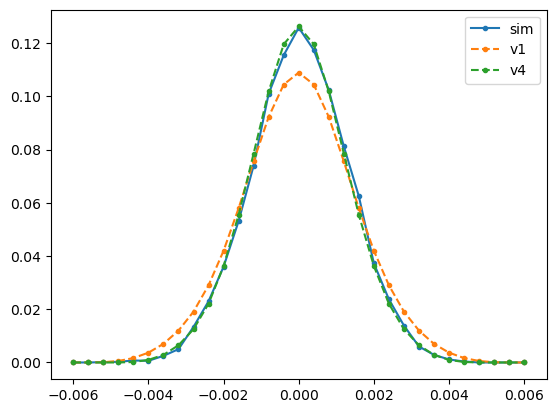

In [324]:
idx = 30
plt.plot(x_s,sim_hists[f*(idx+ntau+1)]/N_p,'.-', label='sim')
plt.plot(x_s,hists[idx],'.--', label='v1')
#plt.plot(x_s,hists2[idx],'.-')
#plt.plot(x_s,hists3[idx],'.-')
plt.plot(x_s,hists4[idx],'.--', label = 'v4')
plt.legend()

In [314]:
sim_var = np.var(pos, axis = 1)
sim_p = sim_hists/np.sum(sim_hists, axis = 1)[:,None]
sim_hist_var = np.sum(sim_p*x_s[None,:]**2 - (sim_p*x_s[None,:])**2, axis = 1)

num_p = hists[:,:]/np.sum(hists, axis = 1)[:,None]
num_var = np.sum(num_p*x_s[None,:]**2 - (num_p*x_s[None,:])**2, axis = 1)

#num_p_2 = hists2[:,:]/np.sum(hists2, axis = 1)[:,None]
#num_var_2 = np.sum(num_p_2*x_s[None,:]**2 - (num_p_2*x_s[None,:])**2, axis = 1)

#num_p_3 = hists3[:,:]/np.sum(hists3, axis = 1)[:,None]
#num_var_3 = np.sum(num_p_3*x_s[None,:]**2 - (num_p_3*x_s[None,:])**2, axis = 1)

num_p_4 = hists4[:,:]/np.sum(hists4, axis = 1)[:,None]
num_var_4 = np.sum(num_p_4*x_s[None,:]**2 - (num_p_4*x_s[None,:])**2, axis = 1)

In [315]:
tau

0.4

(0.0, 2.0)

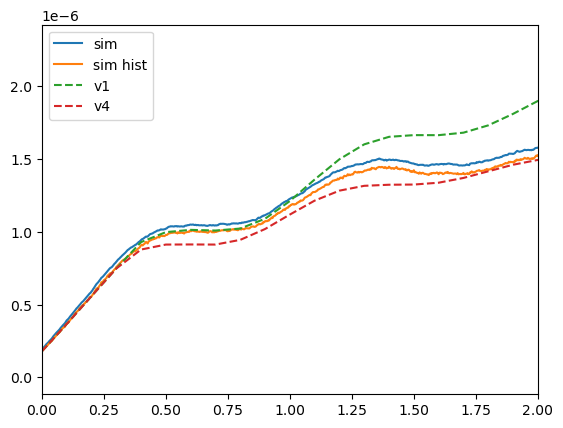

In [317]:
plt.plot(sim_ts,sim_var[0], label='sim')
plt.plot(sim_ts,sim_hist_var, label='sim hist')
plt.plot(ts, num_var, label='v1', ls = '--')
#plt.plot(ts, num_var_2, label='v2',ls =  '--')
#plt.plot(ts, num_var_3, label='v3',ls =  '--')
plt.plot(ts, num_var_4, label='v4',ls =  '--')
plt.legend()
plt.xlim(0,2)

In [319]:
print(np.mean(sim_var[0,-f*N_t//2:]))
print(np.mean(sim_hist_var[-f*N_t//2:]))
print()
print(np.mean(num_var[-N_t//2:]))
print(np.mean(num_var_4[-N_t//2:]))

1.7962576146877355e-06
1.7335133114016182e-06

2.305629417277476e-06
1.6350548345045026e-06


# The loop

In [5]:
k = 3
D = 1e-6
s = np.sqrt(2*D)
N_t = 100
dx = 4e-4 #4e-4
sb = 15*dx#0.005

f = 30
N_p = 8_000


# jump over zero as x point
x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_x = len(x_s)

ltaus = np.array([0.01, 0.05, 0.1, 0.2,0.3,0.4,0.5,0.6])
sim_vars = np.empty(len(ltaus))
num_vars = np.empty(len(ltaus))
num_vars_2 = np.empty(len(ltaus))
sim_hist_vars = np.empty(len(ltaus))

tau_frac = 4

def force(x,*args):
     return -k*x
i_zero = np.argmin(force(x_s)**2)

# for i,ltau in enumerate(tqdm(ltaus)):
    
    
#     ldt = ltau/tau_frac if ltau > 0 else 5e-2
#     lntau = round(ltau/ldt)
    
#     print(ldt, lntau)
#     prop = get_prop_v2(x_s, force,D,ldt,dx)
#     hists, unaltered_props, total_prob = get_hists_v4(N_t = N_t, N_x=N_x,ntau=lntau,i_zero=i_zero,prop=prop)
    
#     #prop2 = get_prop_v2(x_s, force,D,ldt,dx)
#     #hists2, unaltered_props2, total_prob2 = get_hists_v2(N_t = N_t, N_x=N_x,ntau=lntau,i_zero=i_zero,prop=prop2)
    
    
#     pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+lntau+2)*f, ntau=lntau*f, s=s, dt=ldt/f,border=0, force=force)
#     all_pos = pos[0]
#     sim_hists = [np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]))]
 
#     sim_var = np.var(pos, axis = 1)
#     sim_p = sim_hists/np.sum(sim_hists, axis = 1)[:,None]
#     sim_hist_var = np.sum(sim_p*x_s[None,:]**2 - (sim_p*x_s[None,:])**2, axis = 1)
    
#     num_p = hists[:,:]/np.sum(hists, axis = 1)[:,None]
#     num_var = np.sum(num_p*x_s[None,:]**2 - (num_p*x_s[None,:])**2, axis = 1)

#     #num_p_2 = hists2[:,:]/np.sum(hists2, axis = 1)[:,None]
#     #num_var_2 = np.sum(num_p_2*x_s[None,:]**2 - (num_p_2*x_s[None,:])**2, axis = 1)
    
#     sim_vars[i] = np.mean(sim_var[0,-f*N_t//2:])
#     num_vars[i] = np.mean(num_var[-N_t//2:])
#     sim_hist_vars[i] = np.mean(sim_hist_var[-f*N_t//2:])
#     #num_vars_2[i] = np.mean(num_var_2[-N_t//2:])
    
# with open(f'nummeric_results/sim_vs_num_v4_emb{tau_frac}.pkl', 'wb') as file:
#     pickle.dump({'ltaus':ltaus,
#                  'sim_vars':sim_vars,
#                  'sim_hist_vars':sim_hist_vars,
#                  'num_vars':num_vars
#                 }, file)

In [6]:
# sim_vs_num_v2 = pickle.load(open('nummeric_results/sim_vs_num_v2_emb4.pkl', 'rb'))
# ltaus = sim_vs_num_v2['ltaus']
# sim_vars = sim_vs_num_v2['sim_vars']
# num_vars = sim_vs_num_v2['num_vars']
# num_vars_2 = sim_vs_num_v2['num_vars_2']

sim_vs_num_v4 = pickle.load(open('nummeric_results/sim_vs_num_v4_emb4.pkl', 'rb'))
ltaus = sim_vs_num_v4['ltaus']
sim_vars = sim_vs_num_v4['sim_vars']
num_vars = sim_vs_num_v4['num_vars']
sim_hist_vars = sim_vs_num_v4['sim_hist_vars']

In [7]:
short_time_approx_var = s**2/(2*k)*(1+k*ltaus)
exact_sol = s**2/(2*k)*(1+np.sin(k*ltaus))/np.cos(k*ltaus)

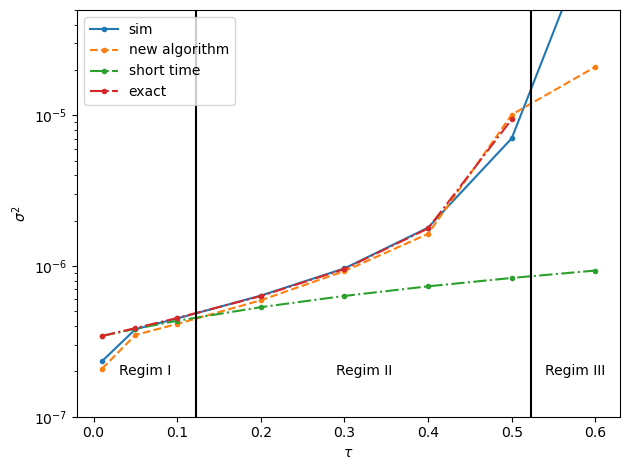

In [28]:
ax = plt.subplot()
plt.plot(ltaus,sim_vars,'.-', label='sim')
#plt.plot(ltaus,sim_hist_vars,'.-', label='hist-sim')
plt.plot(ltaus,num_vars,'.--', label='new algorithm')
#plt.plot(ltaus,num_vars_2,'.--' ,label='v2')
plt.plot(ltaus,short_time_approx_var ,'.-.',label='short time')
plt.plot(ltaus[:-1],exact_sol[:-1] ,'.-.',label='exact')

plt.ylim(1e-7,5e-5)
plt.vlines([1/np.e /k, np.pi/2/k],*plt.ylim(), color='black')
plt.text(0.5*1/np.e /k,              2e-7,'Regim I', ha='center', va='center')
plt.text(0.5*(1/np.e /k+  np.pi/2/k),2e-7,'Regim II',ha='center', va='center')
plt.text(1.1*(np.pi/2/k),            2e-7,'Regim III',ha='center', va='center')

plt.yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^2$')
plt.tight_layout()
plt.savefig('Graphic_Results/varianz_compare.pdf')

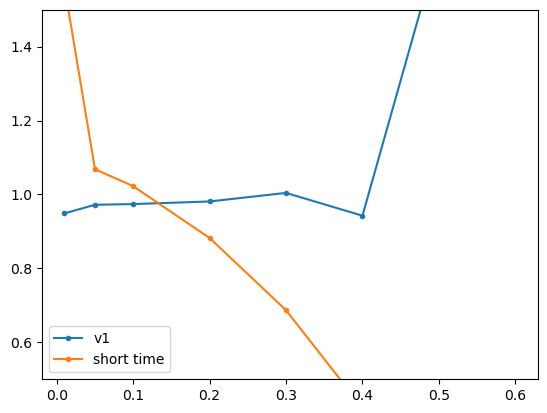

In [29]:
plt.plot(ltaus,num_vars/sim_hist_vars,'.-', label='v1')
#plt.plot(ltaus,num_vars_2/sim_vars,label='v2')
plt.plot(ltaus,short_time_approx_var/sim_hist_vars,'.-',label='short time')
plt.ylim(0.5,1.5)
plt.legend()

In [18]:
## 
max_i = 40
test_arr = np.random.randint(0, max_i, (200_000,6))
test_probs = np.random.random(200_000)

In [89]:
%%timeit
np.unique(test_arr, axis = 0,return_inverse=True, return_index=True)

333 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [131]:
%%timeit
np.unique(np.sum(test_arr * (max_i**np.arange(5,-1,-1)), axis = 1),return_inverse=True, return_index=True, return_counts=True)

26.4 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [94]:
# import pandas as pd

# %%timeit
# pd.unique(np.sum(test_arr * (max_i**np.arange(5,-1,-1)), axis = 1))

In [137]:
items,a,b,c = np.unique(np.sum(test_arr * (max_i**np.arange(5,-1,-1)), axis = 1), return_inverse=True, return_index=True, return_counts=True)

In [145]:
new_test_prob = np.stack([np.sum(test_probs[b == i]) if c[i] > 1 else  test_probs[a[i]] for i in range(len(a))])

In [146]:
len(new_test_prob)

199995

In [148]:
(new_test_prob > 1).sum()

4

In [64]:

S = dok_array((60,1), dtype=np.int64)

In [65]:
S[1,0] += 1

In [89]:
S[np.array([1,2,3]),[0]] = np.array([1,2,3])

In [19]:

%%timeit
test_arr[:,:-1] = test_arr[:,1:]
test_arr[:,-1]  = 2

5.44 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
test_ints = np.sum(test_arr * (max_i**np.arange(5,-1,-1)), axis = 1)

In [27]:
%%timeit
a = test_ints//max_i + 2*max_i**5

448 µs ± 8.52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [79]:
S

<60x1 sparse array of type '<class 'numpy.int64'>'
	with 3 stored elements in Dictionary Of Keys format>

In [80]:
S.clear()

In [120]:
print((S[np.array([1,2,3,4,5]),[0]] != 0).todense())

[[ True  True  True False False]]


In [150]:
S[62,0]

IndexError: row index (62) out of range